### Provide by

นายธนชาติ เสถียรจารุการ 63340500021 <br>

นายพชพล เพชรรัตน์ 63340500036 <br>

นายพร้อม

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, silhouette_score, v_measure_score, f1_score

RandomState = 1

### Setting up for exploration

##### match data

In [134]:
match_df = pd.read_csv('match.csv')
match_df = match_df.drop(['start_time','game_mode', 'negative_votes', 'positive_votes', 'cluster'], axis=1)
match_df['radiant_win'] = match_df['radiant_win'].replace([False, True], [0, 1])
match_df.head()

,match_id,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,radiant_win
0,0,2375,1982,4,3,63,1,1
1,1,2582,0,1846,63,0,221,0
2,2,2716,256,1972,63,48,190,0
3,3,3085,4,1924,51,3,40,0
4,4,1887,2047,0,0,63,58,1


##### player stat in any match

In [139]:
player_df = pd.read_csv('players.csv')
player_df = player_df.iloc[:, 0:25]
player_df = player_df.drop(['gold', 'account_id', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5'], axis=1)
player_df['stuns'] = player_df['stuns'].replace(['None'], [0.0])
player_df['stuns'] = player_df['stuns'].astype(np.float64)
player_df['leaver_status'] = player_df['leaver_status'].replace(list(range(5)), [0, 0, 1, 1, 1])
player_df.head()

,match_id,hero_id,player_slot,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level,leaver_status
0,0,86,0,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,16,0
1,0,51,1,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,22,0
2,0,83,2,12195,350,385,0,4,15,1,58,0.0000,4217,1595,399,17,0
3,0,11,3,22505,599,605,8,4,19,6,271,0.0000,14832,2714,6055,21,0
4,0,67,4,23825,613,762,20,3,17,13,245,0.0000,33740,243,1833,24,0


- sum of feature values of each team

In [14]:
cols = list(player_df.columns)
cols = [i for i in cols if i!='match_id' and i!='hero_id' and i!='player_slot']
sum_data = {}
index = []
for j in cols:
    sum_data.update({'radiant_total_'+str(j):[],
                        'dire_total_'+str(j):[]})
for i in tqdm(range(match_df.shape[0])):
    a = player_df.loc[player_df['match_id']==i]
    radiant = a.loc[a['player_slot']<=4]
    dire = a.loc[a['player_slot']>4]
    index.append(i)
    for j in cols:
        sum_data['radiant_total_'+str(j)].append(radiant[j].sum())
        sum_data['dire_total_'+str(j)].append(dire[j].sum())

##### create new dataframe and export
new_df = pd.concat([match_df, pd.DataFrame(data=sum_data, index=index)], axis=1)
# new_df.to_csv("new_match_df.csv")

100%|██████████| 50000/50000 [02:37<00:00, 316.59it/s]


- what is the most hero picked?
    - most pick is zeus
    - less pick is anti-mage

In [ ]:
print(player_df['hero_id'].value_counts())

##### team fight in match

In [5]:
teamfight_df = pd.read_csv('teamfights.csv')
teamfight_df.head()

,match_id,start,end,last_death,deaths
0,0,220,252,237,3
1,0,429,475,460,3
2,0,900,936,921,3
3,0,1284,1328,1313,3
4,0,1614,1666,1651,5


##### player info in team fight

In [2]:
teamfight_player_df = pd.read_csv('teamfights_players.csv')
teamfight_player_df = teamfight_player_df.rename(columns={'gold_delta': 'delta_gold'})
teamfight_player_df['delta_xp'] = teamfight_player_df['xp_end']-teamfight_player_df['xp_start']
teamfight_player_df.head()

,match_id,player_slot,buybacks,damage,deaths,delta_gold,xp_end,xp_start,delta_xp
0,0,0,0,105,0,173,536,314,222
1,0,1,0,566,1,0,1583,1418,165
2,0,2,0,0,0,0,391,391,0
3,0,3,0,0,0,123,1775,1419,356
4,0,4,0,444,0,336,1267,983,284


- sum of value in every match of each team

In [3]:
feature_list = ['delta_gold', 'delta_xp']
itertime = 0
sum_data = {}
index = []
for i in feature_list:
    sum_data.update({'radiant_total_'+str(i):[],
                        'dire_total_'+str(i):[]})
for i in tqdm(range(match_df.shape[0])):
    select_match = teamfight_player_df.loc[teamfight_player_df['match_id']==i]
    fight_num = int((select_match.shape[0])/10)
    for j in range(fight_num):
        index.append(itertime)
        one_teamfight = select_match.iloc[(10*j):(10*(j+1)),:]
        radiant = one_teamfight.loc[one_teamfight['player_slot']<=4]
        dire = one_teamfight.loc[one_teamfight['player_slot']>4]
        for k in feature_list:
            sum_data['radiant_total_'+str(k)].append(radiant[k].sum())
            sum_data['dire_total_'+str(k)].append(dire[k].sum())
        itertime += 1

##### create new dataframe and export
sum_teamfight_df = pd.DataFrame(data=sum_data, index=index)
new_teamfight_df = pd.concat([teamfight_df[['match_id', 'start', 'end']], sum_teamfight_df], axis=1)
new_teamfight_df.head()
# new_teamfight_df.to_csv("./new_dataframe/new_teamfight_df.csv")

100%|██████████| 50000/50000 [11:51<00:00, 70.25it/s]


##### explore player time dataframe

In [19]:
player_time_df = pd.read_csv('player_time.csv')
player_time_df.head()

,match_id,times,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,...,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,60,409,0,63,142,1,186,168,0,...,62,345,6,351,100,0,77,613,1,125
2,0,120,546,0,283,622,4,645,330,0,...,543,684,12,805,200,0,210,815,5,323
3,0,180,683,1,314,927,9,1202,430,0,...,842,958,16,1135,300,0,210,1290,8,527
4,0,240,956,1,485,1264,11,1583,530,0,...,1048,1500,26,1842,400,0,210,1431,9,589


In [75]:
cols = ['gold_t_', 'xp_t_', 'lh_t_']
time_stat = {}
itertime = 0
index = []
for i in cols:
    time_stat.update({'radiant_'+str(i):[], 'dire_'+str(i):[]})
    for j in range(5):
        time_stat['radiant_'+str(i)].append(str(i)+str(j))
        time_stat['dire_'+str(i)].append(str(i)+str(j+128))
    time_stat.update({'radiant_'+str(i):player_time_df[time_stat['radiant_'+str(i)]].sum(axis=1), 
                        'dire_'+str(i):player_time_df[time_stat['dire_'+str(i)]].sum(axis=1)})


In [93]:
new_time_stat_df = pd.concat([player_time_df[['match_id', 'times']], pd.DataFrame(data=time_stat)], axis=1)
# new_time_stat_df.to_csv("./new_dataframe/new_time_stat_df.csv")
new_time_stat_df.head()

In [ ]:
test = player_time_df.loc[player_time_df['match_id']==0]
fig, ax = plt.subplots(figsize=(8, 3))
for i in range(5):
    ax.scatter(test['times'], test['gold_t_'+str(i)], label='player'+str(i), c='r', s=5)
    ax.plot(test['times'], test['gold_t_'+str(i)], c='r')
for i in range(128,133,1):
    ax.scatter(test['times'], test['gold_t_'+str(i)], label='player'+str(i), c='b', s=5)
    ax.plot(test['times'], test['gold_t_'+str(i)], c='b')
ax.set_xlabel("times")
ax.set_ylabel("gold")
plt.legend(loc='upper left')
plt.show()

- declare function

In [18]:
def plotHistrogram(df:pd.DataFrame, hue=None):
    cols = df.columns
    plot_cols = 5
    plot_row = round((len(cols)/plot_cols)+1)
    plot_num = 1
    plt.figure(figsize=(plot_cols*6, plot_row*6))
    for i in tqdm(cols):
        ax = plt.subplot(plot_row, plot_cols, plot_num)
        sns.histplot(data=df, x=i, kde=True, hue=hue)
        plot_num += 1
    plt.show()

def plotScatter(df:pd.DataFrame, hue=None):
    cols = df.columns
    plot_cols = len(cols)
    plot_row = len(cols)
    plot_num = 1
    plt.figure(figsize=(plot_cols*8, plot_row*8))
    for i in tqdm(cols):
        for j in cols:
            ax = plt.subplot(plot_row, plot_cols, plot_num)
            sns.scatterplot(data=df, x=i, y=j, hue=hue)
            plot_num += 1
    plt.show()

def removeNumericalOutlier(df:pd.DataFrame, feature_list:list):
    new_df = df.copy()
    for feature in feature_list:       
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5*IQR
        upper_bound = q3 + 1.5*IQR
        new_df = new_df[(new_df[feature]>lower_bound)&(new_df[feature]<upper_bound)]
    return new_df

def clusterKMean(df:pd.DataFrame):
    scaler = MinMaxScaler()
    x_scale = scaler.fit_transform(df.values)
    scale_df = pd.DataFrame(x_scale, columns=df.columns)
    res = {}
    for i in tqdm(range(2,11,1)):
        model = KMeans(n_clusters=int(i), max_iter=1000 , random_state=RandomState)
        model.fit(scale_df)
        res.update({i:{'model':model,
                        'WCSS':model.inertia_,
                        'silhouette_score':silhouette_score(scale_df, model.labels_)}})
    return res

def plotClusteringScore(res_kmean):
    kmean_num = list(res_kmean.keys())
    kmean_WCSS = [res_kmean[i]['WCSS'] for i in kmean_num]
    kmean_sil_score = [res_kmean[i]['silhouette_score'] for i in kmean_num]
    
    fig, ax = plt.subplots(ncols=2, figsize=(14, 3))
    ax[0].scatter(kmean_num, kmean_WCSS)
    ax[0].plot(kmean_num, kmean_WCSS)
    ax[0].set_xlabel("K")
    ax[0].set_ylabel("WCSS")
    
    ax[1].scatter(kmean_num, kmean_sil_score)
    ax[1].plot(kmean_num, kmean_sil_score)
    ax[1].set_xlabel("K")
    ax[1].set_ylabel("silhouette_score")
    
    
    plt.legend(loc='upper right')
    plt.show()


### Data exploration

##### explore teamfight data

In [2]:
new_time_stat_df = pd.read_csv("./new_dataframe/new_time_stat_df.csv", index_col=0)
new_teamfight_df = pd.read_csv("./new_dataframe/new_teamfight_df.csv", index_col=0)
##### calculate time before team fight and merge to team status on times
new_teamfight_df['time_before_fight'] = new_teamfight_df['start'] - new_teamfight_df['start']%60
new_teamfight_df = new_teamfight_df.drop(['start', 'end'], axis=1)
teamfight_status = new_teamfight_df.merge(new_time_stat_df, left_on=['match_id', 'time_before_fight'], right_on=['match_id', 'times'])
teamfight_status = teamfight_status.drop(['times'], axis=1)
teamfight_status.head()

,match_id,radiant_total_delta_gold,dire_total_delta_gold,radiant_total_delta_xp,dire_total_delta_xp,time_before_fight,radiant_gold_t_,dire_gold_t_,radiant_xp_t_,dire_xp_t_,radiant_lh_t_,dire_lh_t_
0,0,632,790,1027,812,180,3490,4057,3634,3543,23,40
1,0,1929,345,2436,1140,420,8544,9766,9060,8945,77,108
2,0,3145,-506,4553,289,900,23311,22604,24025,22787,243,282
3,0,1872,-112,2992,1022,1260,36570,32326,39106,31538,364,393
4,0,1768,2164,5096,5114,1560,47627,41332,52253,40816,470,466


100%|██████████| 12/12 [00:57<00:00,  4.83s/it]


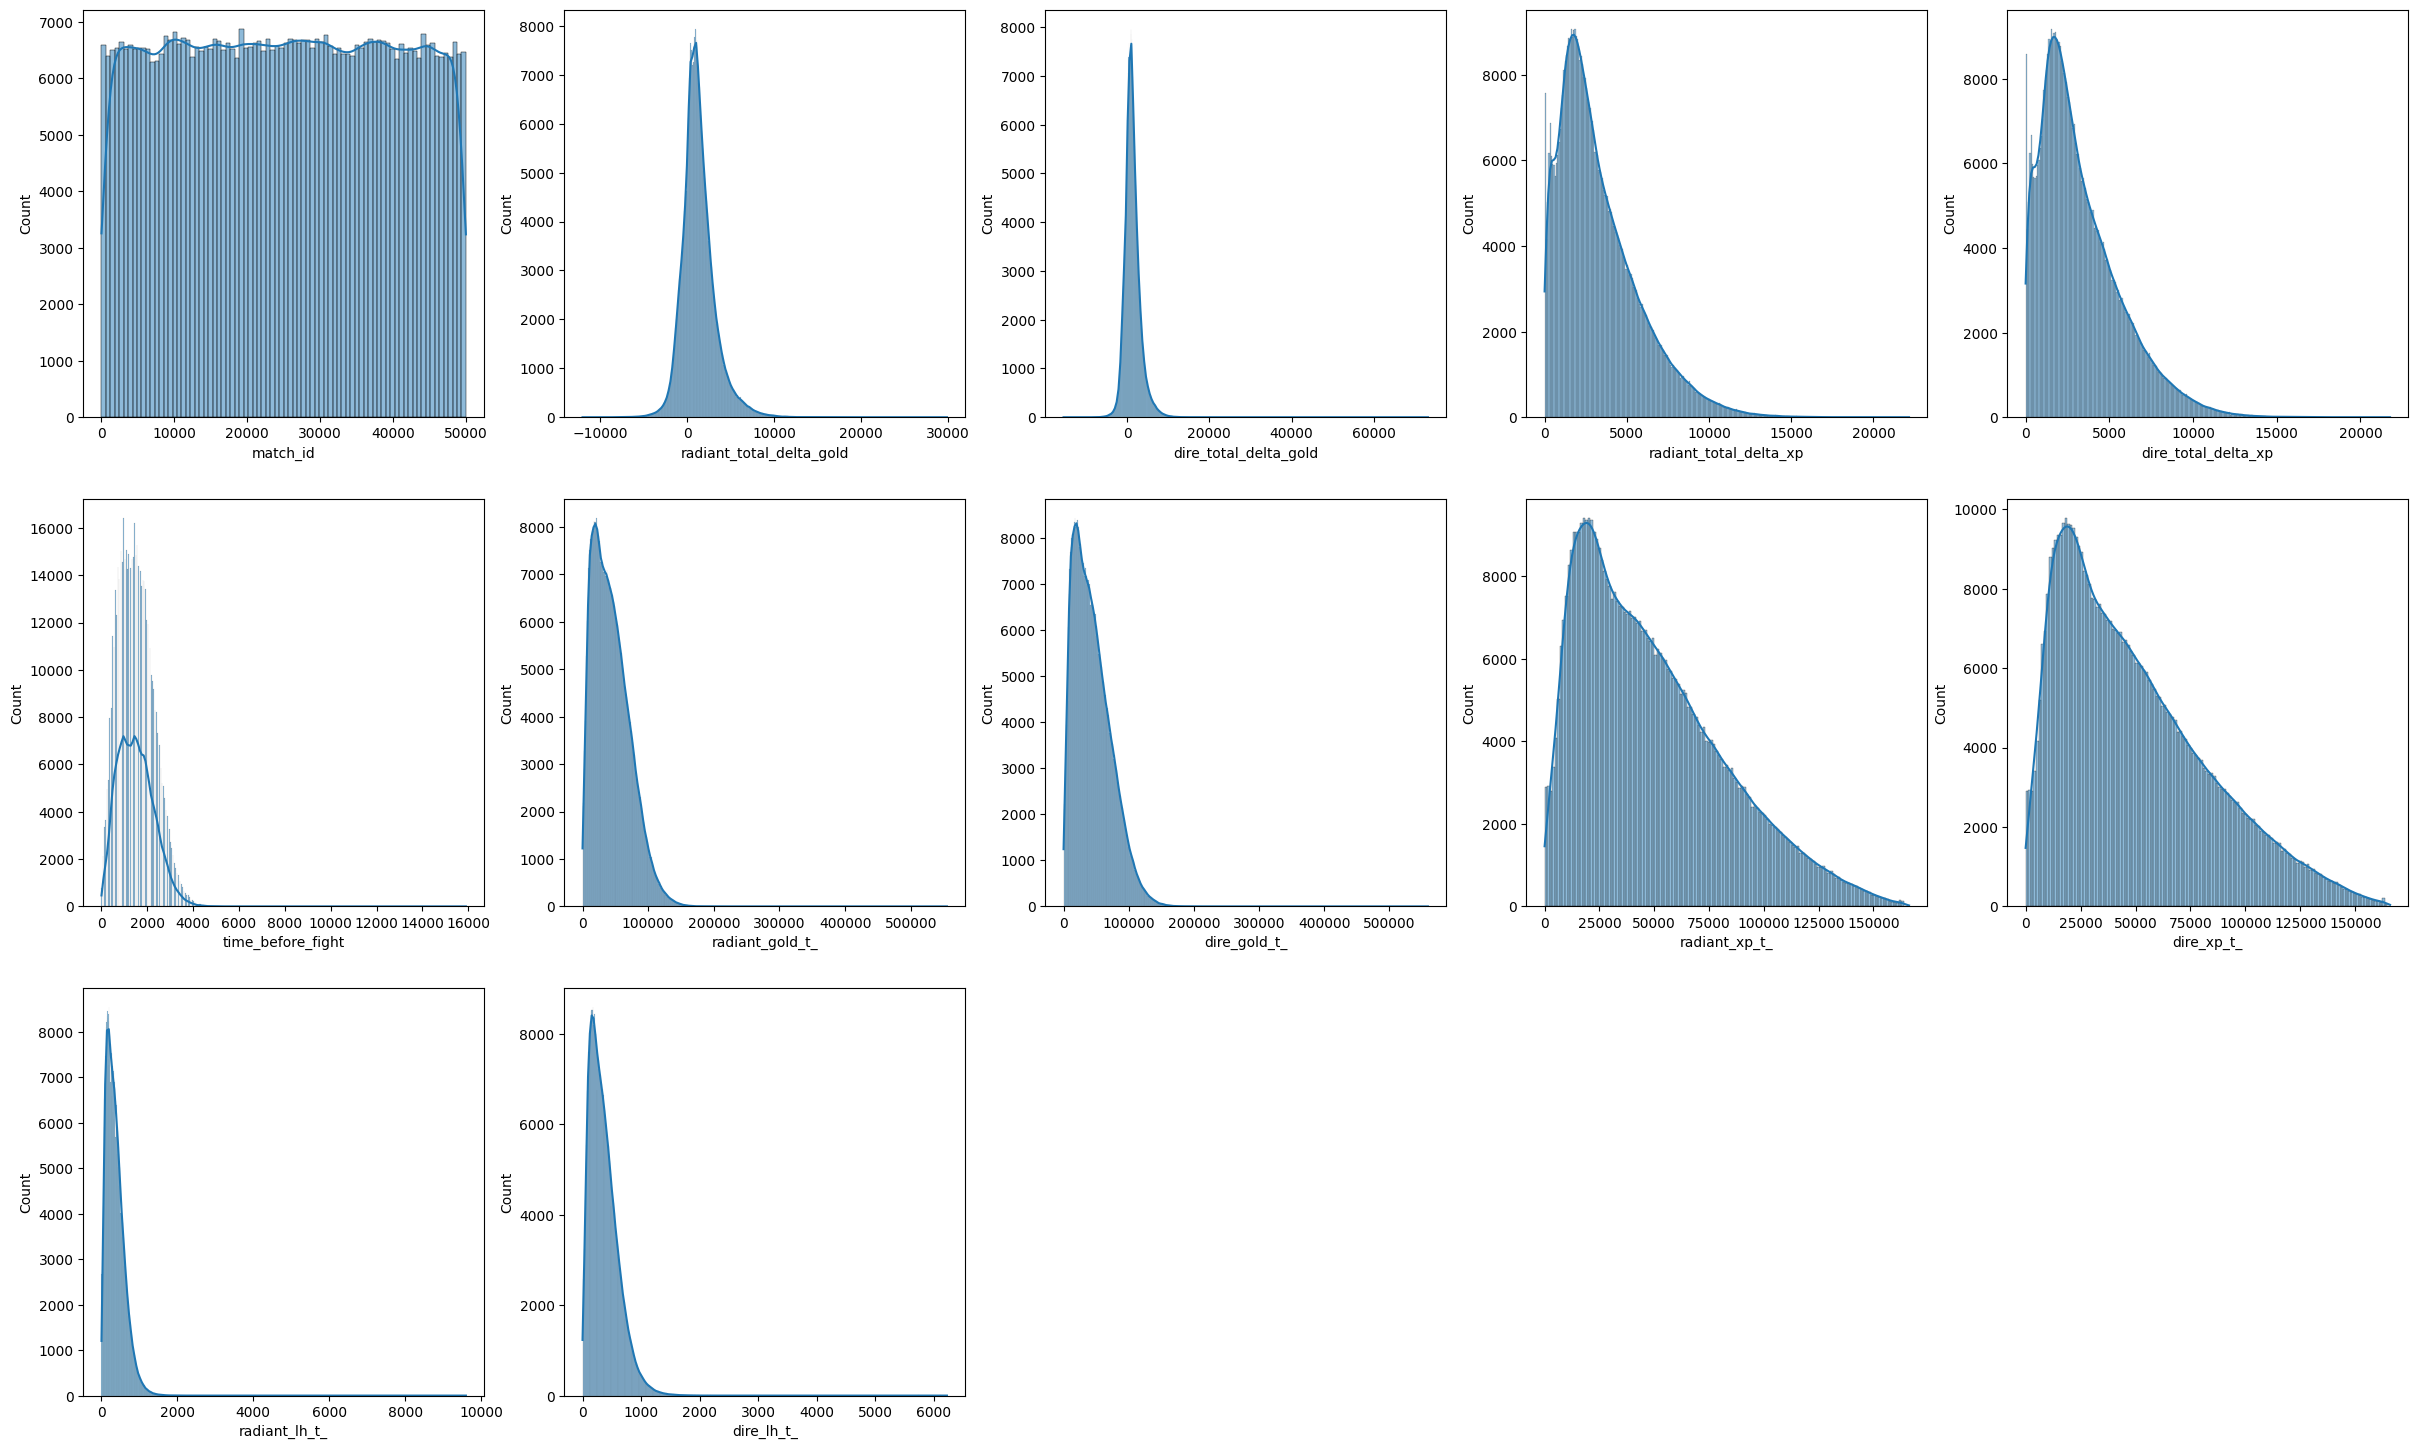

In [156]:
plotHistrogram(teamfight_status.drop(['match_id'], axis=1))

100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


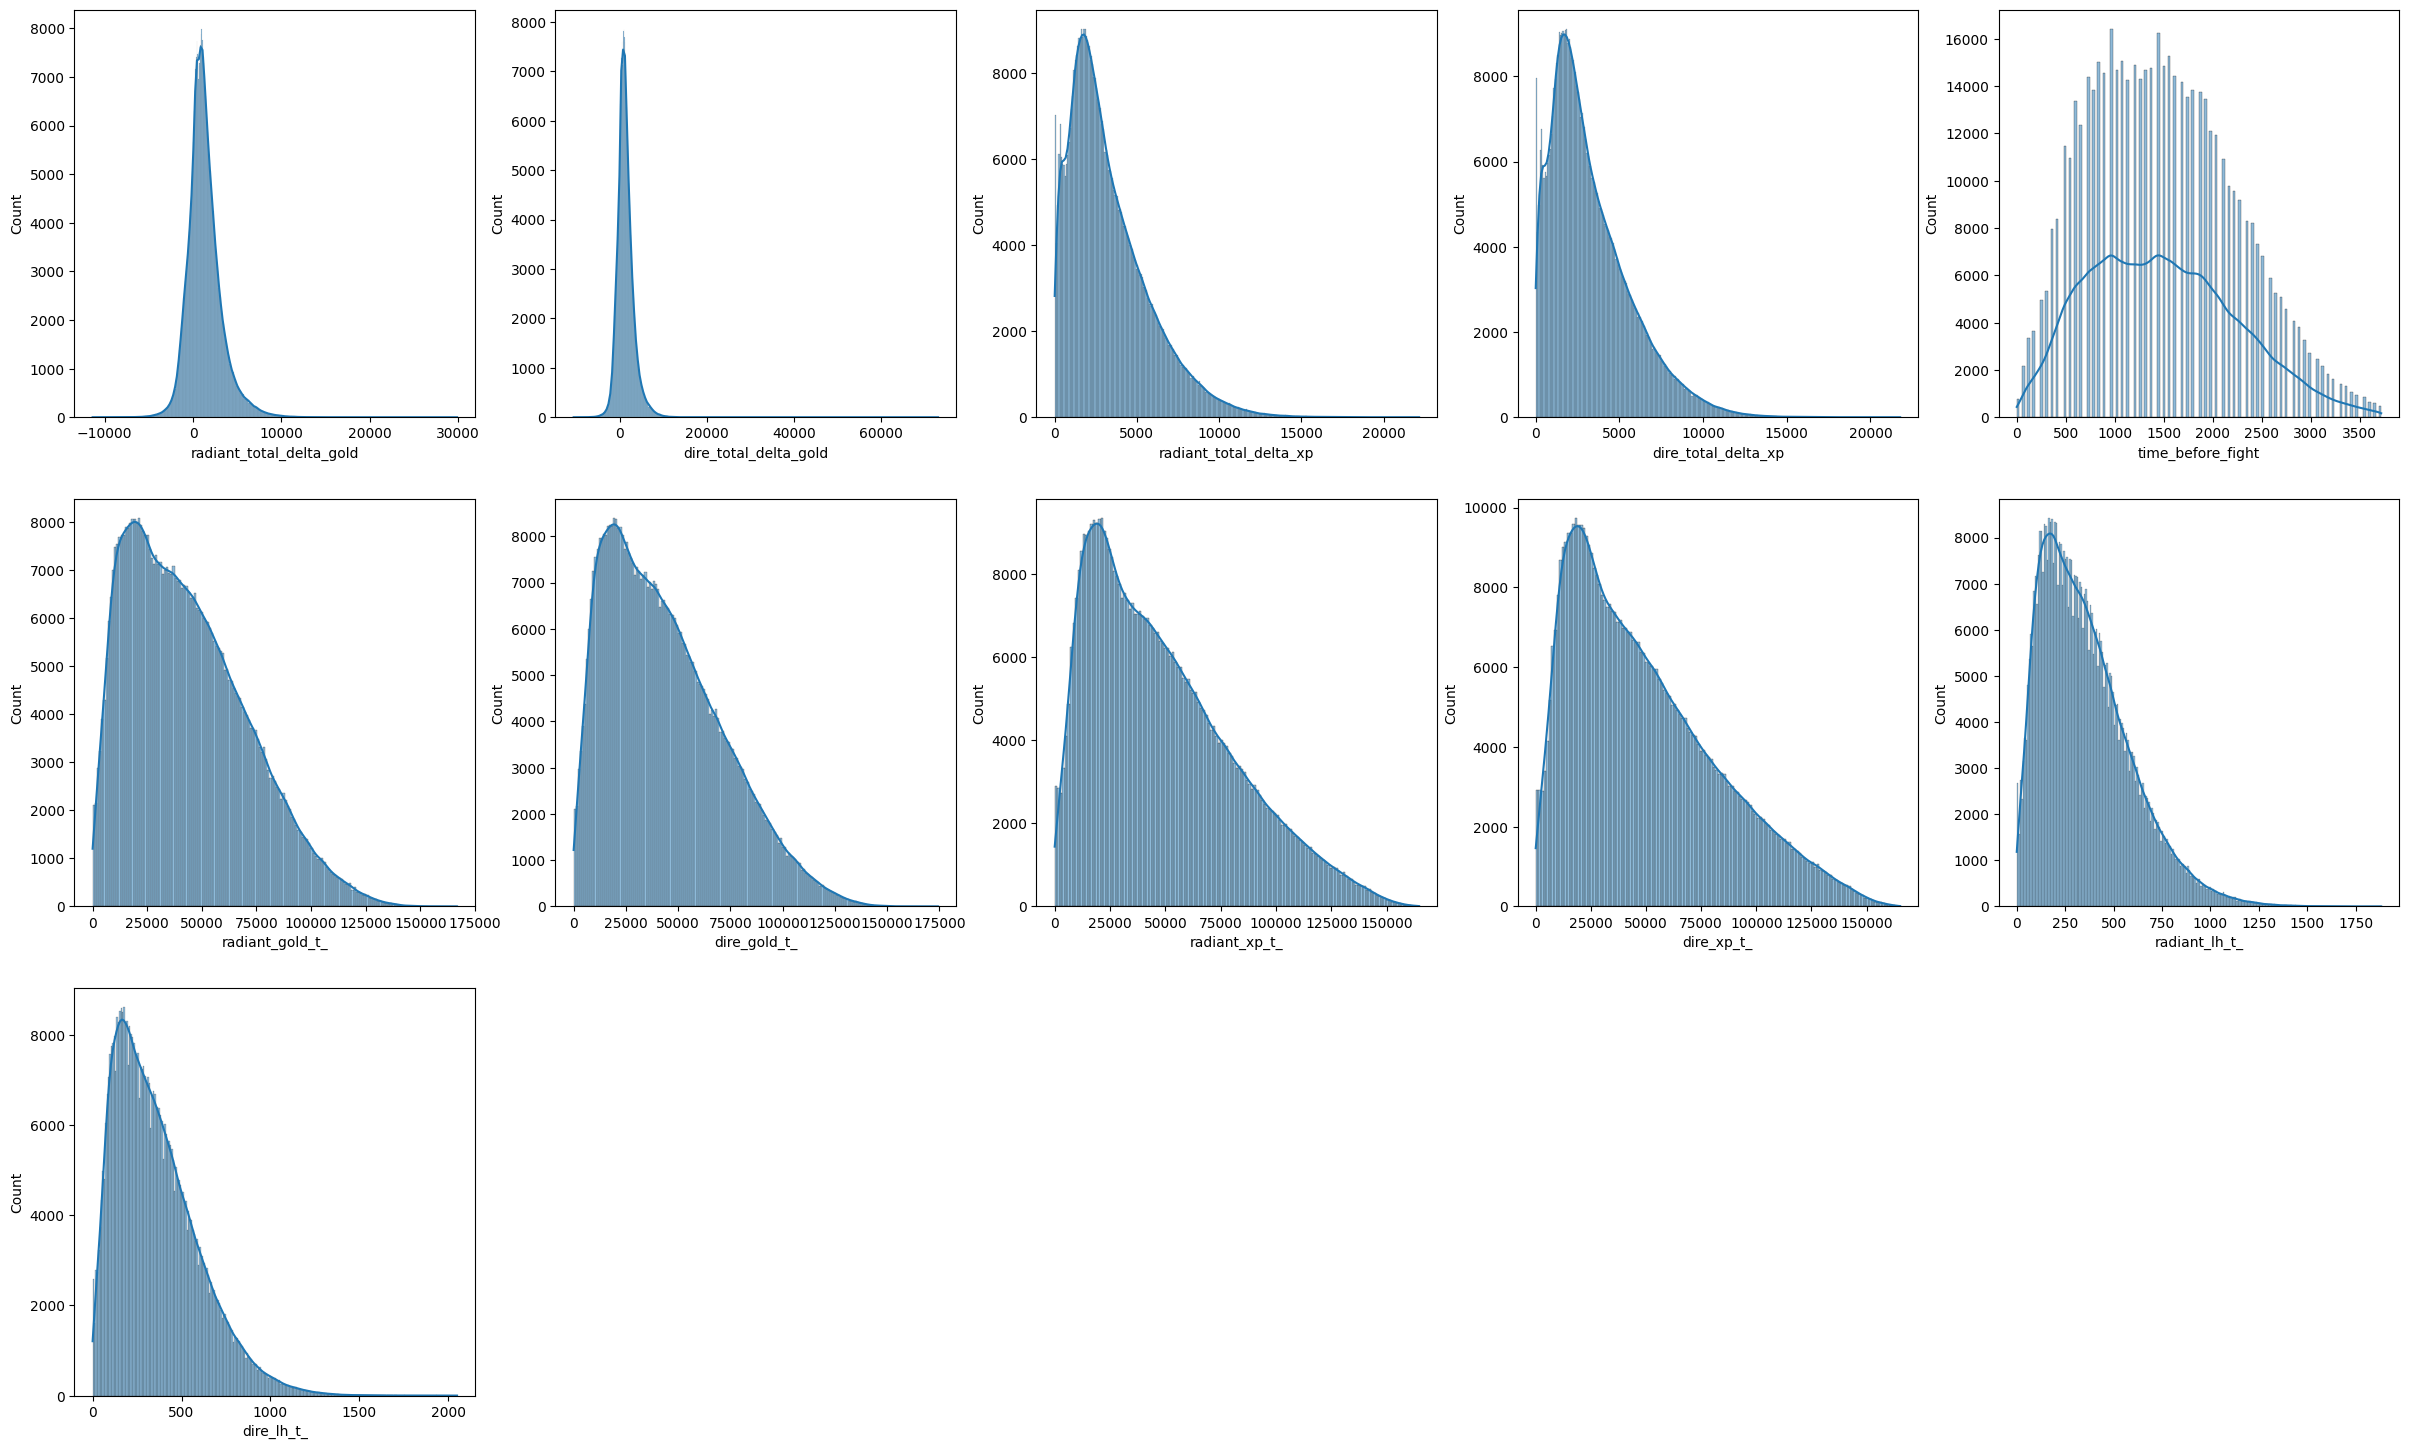

In [165]:
new = removeNumericalOutlier(teamfight_status, ['time_before_fight'])
plotHistrogram(new.drop(['match_id'], axis=1))

In [ ]:
cols = teamfight_status.columns
plot_cols = len(cols)
plot_row = len(cols)
plot_num = 1
plt.figure(figsize=(plot_cols*8, plot_row*8))
for i in tqdm(cols):
    for j in cols:
        ax = plt.subplot(plot_row, plot_cols, plot_num)
        sns.scatterplot(data=teamfight_status, x=i, y=j)
        plot_num += 1
plt.show()

##### explore match data

In [3]:
new_match_df = pd.read_csv("./new_dataframe/new_match_df.csv", index_col=0)
new_match_df.head()

,match_id,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,radiant_win,radiant_total_gold_spent,dire_total_gold_spent,...,radiant_total_hero_damage,dire_total_hero_damage,radiant_total_hero_healing,dire_total_hero_healing,radiant_total_tower_damage,dire_total_tower_damage,radiant_total_level,dire_total_level,radiant_total_leaver_status,dire_total_leaver_status
0,0,2375,1982,4,3,63,1,1,87245,58620,...,85226,47155,4770,1056,8853,2550,100,84,0,0
1,1,2582,0,1846,63,0,221,0,69310,107750,...,58584,93316,0,0,2420,11148,92,111,0,0
2,2,2716,256,1972,63,48,190,0,54990,81620,...,46043,61258,16,1745,1886,7990,80,99,0,0
3,3,3085,4,1924,51,3,40,0,76685,94430,...,86515,107382,10814,1046,4604,9309,110,112,0,0
4,4,1887,2047,0,0,63,58,1,78980,38980,...,57760,50064,2328,446,13062,45,85,65,0,0


100%|██████████| 36/36 [00:14<00:00,  2.44it/s]


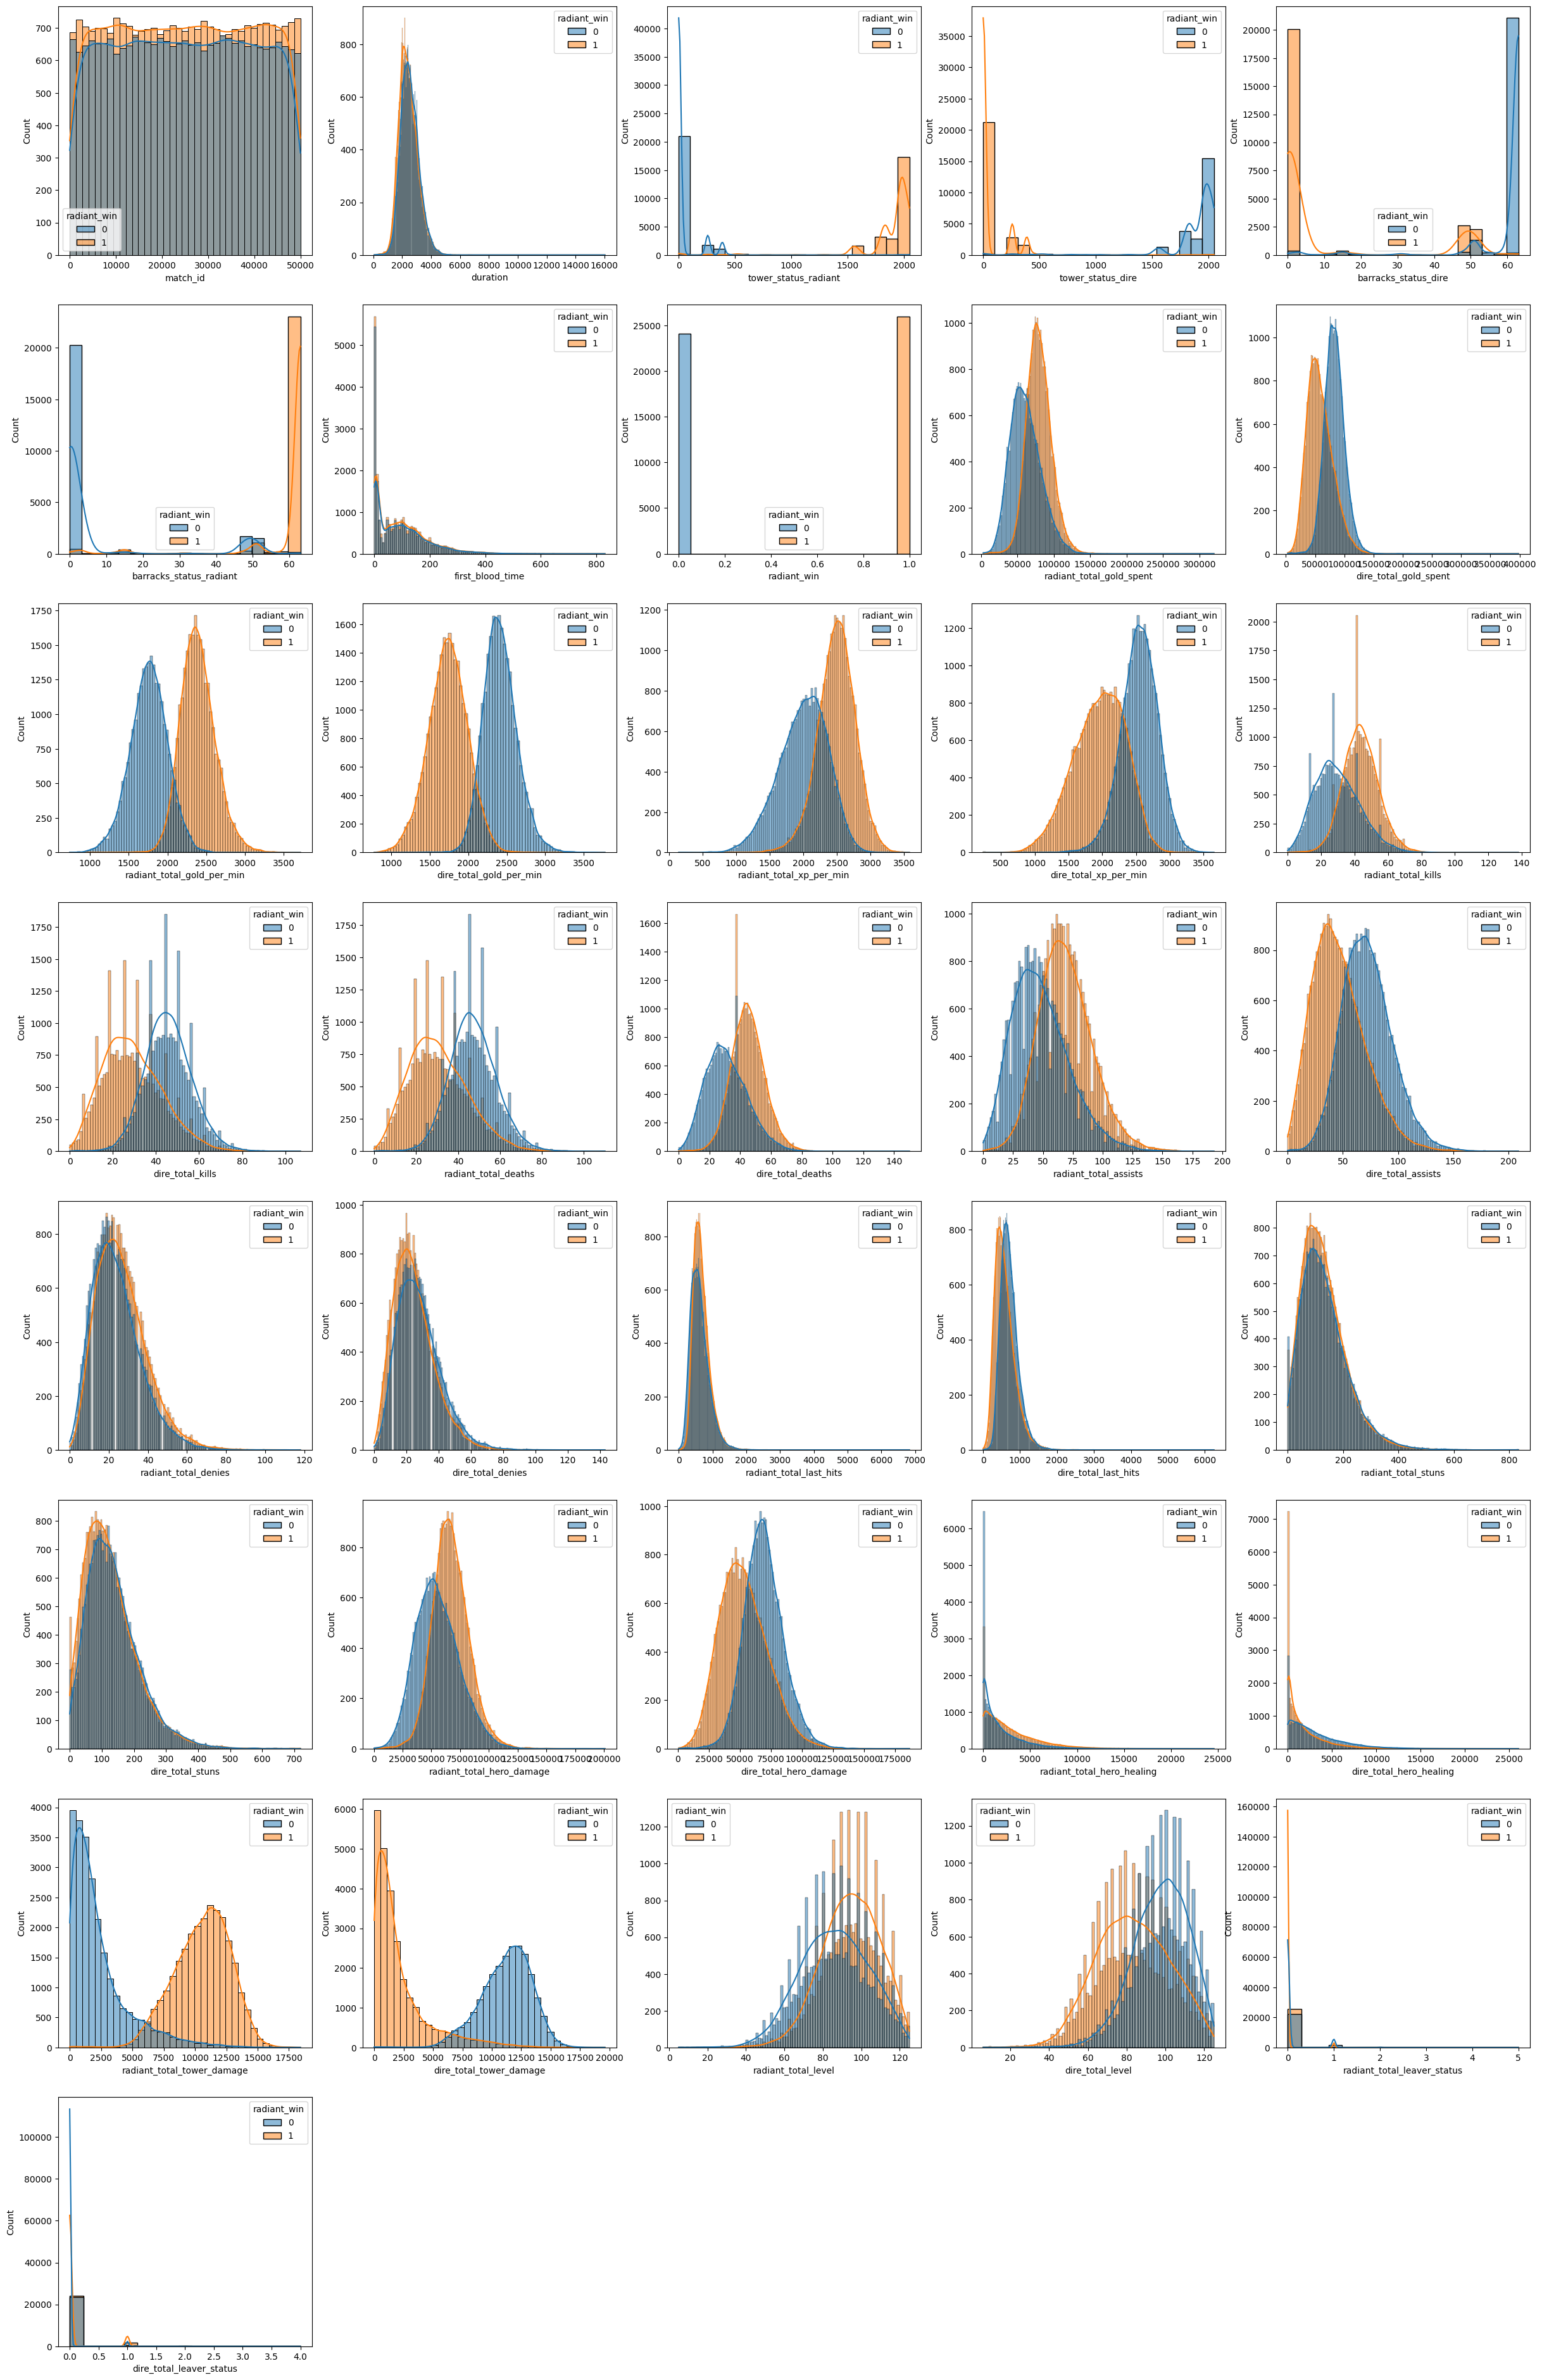

In [168]:
plotHistrogram(new_match_df, hue='radiant_win')

In [ ]:
# plotScatter(new_match_df.drop(['match_id', 'tower_status_radiant', 'tower_status_dire',
                        # 'barracks_status_dire', 'barracks_status_radiant'], axis=1), hue='radiant_win')
df = new_match_df.drop(['match_id', 'tower_status_radiant', 'tower_status_dire',
                        'barracks_status_dire', 'barracks_status_radiant'], axis=1)
cols = df.columns
plot_cols = len(cols)
plot_row = len(cols)
plot_num = 1
plt.figure(figsize=(plot_cols*8, plot_row*8))
for i in tqdm(cols):
    for j in cols:
        ax = plt.subplot(plot_row, plot_cols, plot_num)
        sns.scatterplot(data=df, x=i, y=j, hue='radiant_win')
        plot_num += 1
plt.show()

##### clutering score and statistic

In [4]:
player_df = pd.read_csv('players.csv')
player_df = player_df.iloc[:, 0:25]
player_df = player_df.drop(['gold', 'account_id', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5'], axis=1)
player_df['stuns'] = player_df['stuns'].replace(['None'], [0.0])
player_df['stuns'] = player_df['stuns'].astype(np.float64)
player_df['leaver_status'] = player_df['leaver_status'].replace(list(range(5)), [0, 0, 1, 1, 1])
player_df.head()

,match_id,hero_id,player_slot,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level,leaver_status
0,0,86,0,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,16,0
1,0,51,1,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,22,0
2,0,83,2,12195,350,385,0,4,15,1,58,0.0000,4217,1595,399,17,0
3,0,11,3,22505,599,605,8,4,19,6,271,0.0000,14832,2714,6055,21,0
4,0,67,4,23825,613,762,20,3,17,13,245,0.0000,33740,243,1833,24,0


100%|██████████| 9/9 [5:59:10<00:00, 2394.51s/it]  
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


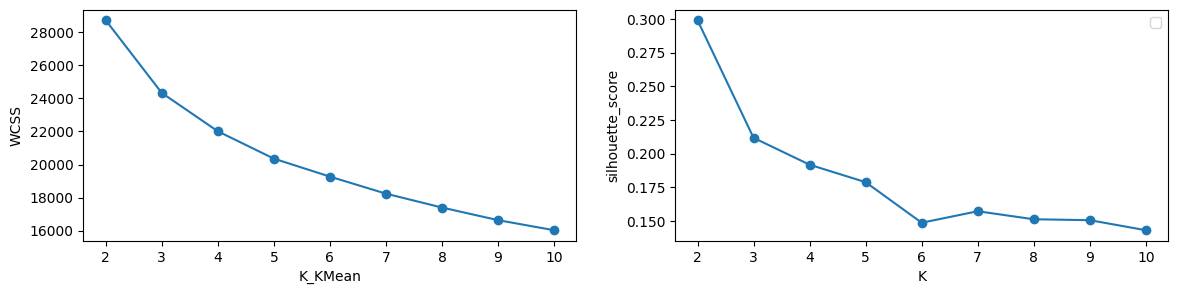

In [7]:
res_player_score_cluster = clusterKMean(player_df[['gold_spent', 'gold_per_min', 'xp_per_min', 'kills', 'deaths', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage', 'hero_healing', 'tower_damage']])
plotClusteringScore(res_player_score_cluster)

In [12]:
player_score_cluster_model = res_player_score_cluster[2]['model']
player_df['kmeans'] = player_score_cluster_model.labels_

100%|██████████| 18/18 [01:05<00:00,  3.66s/it]


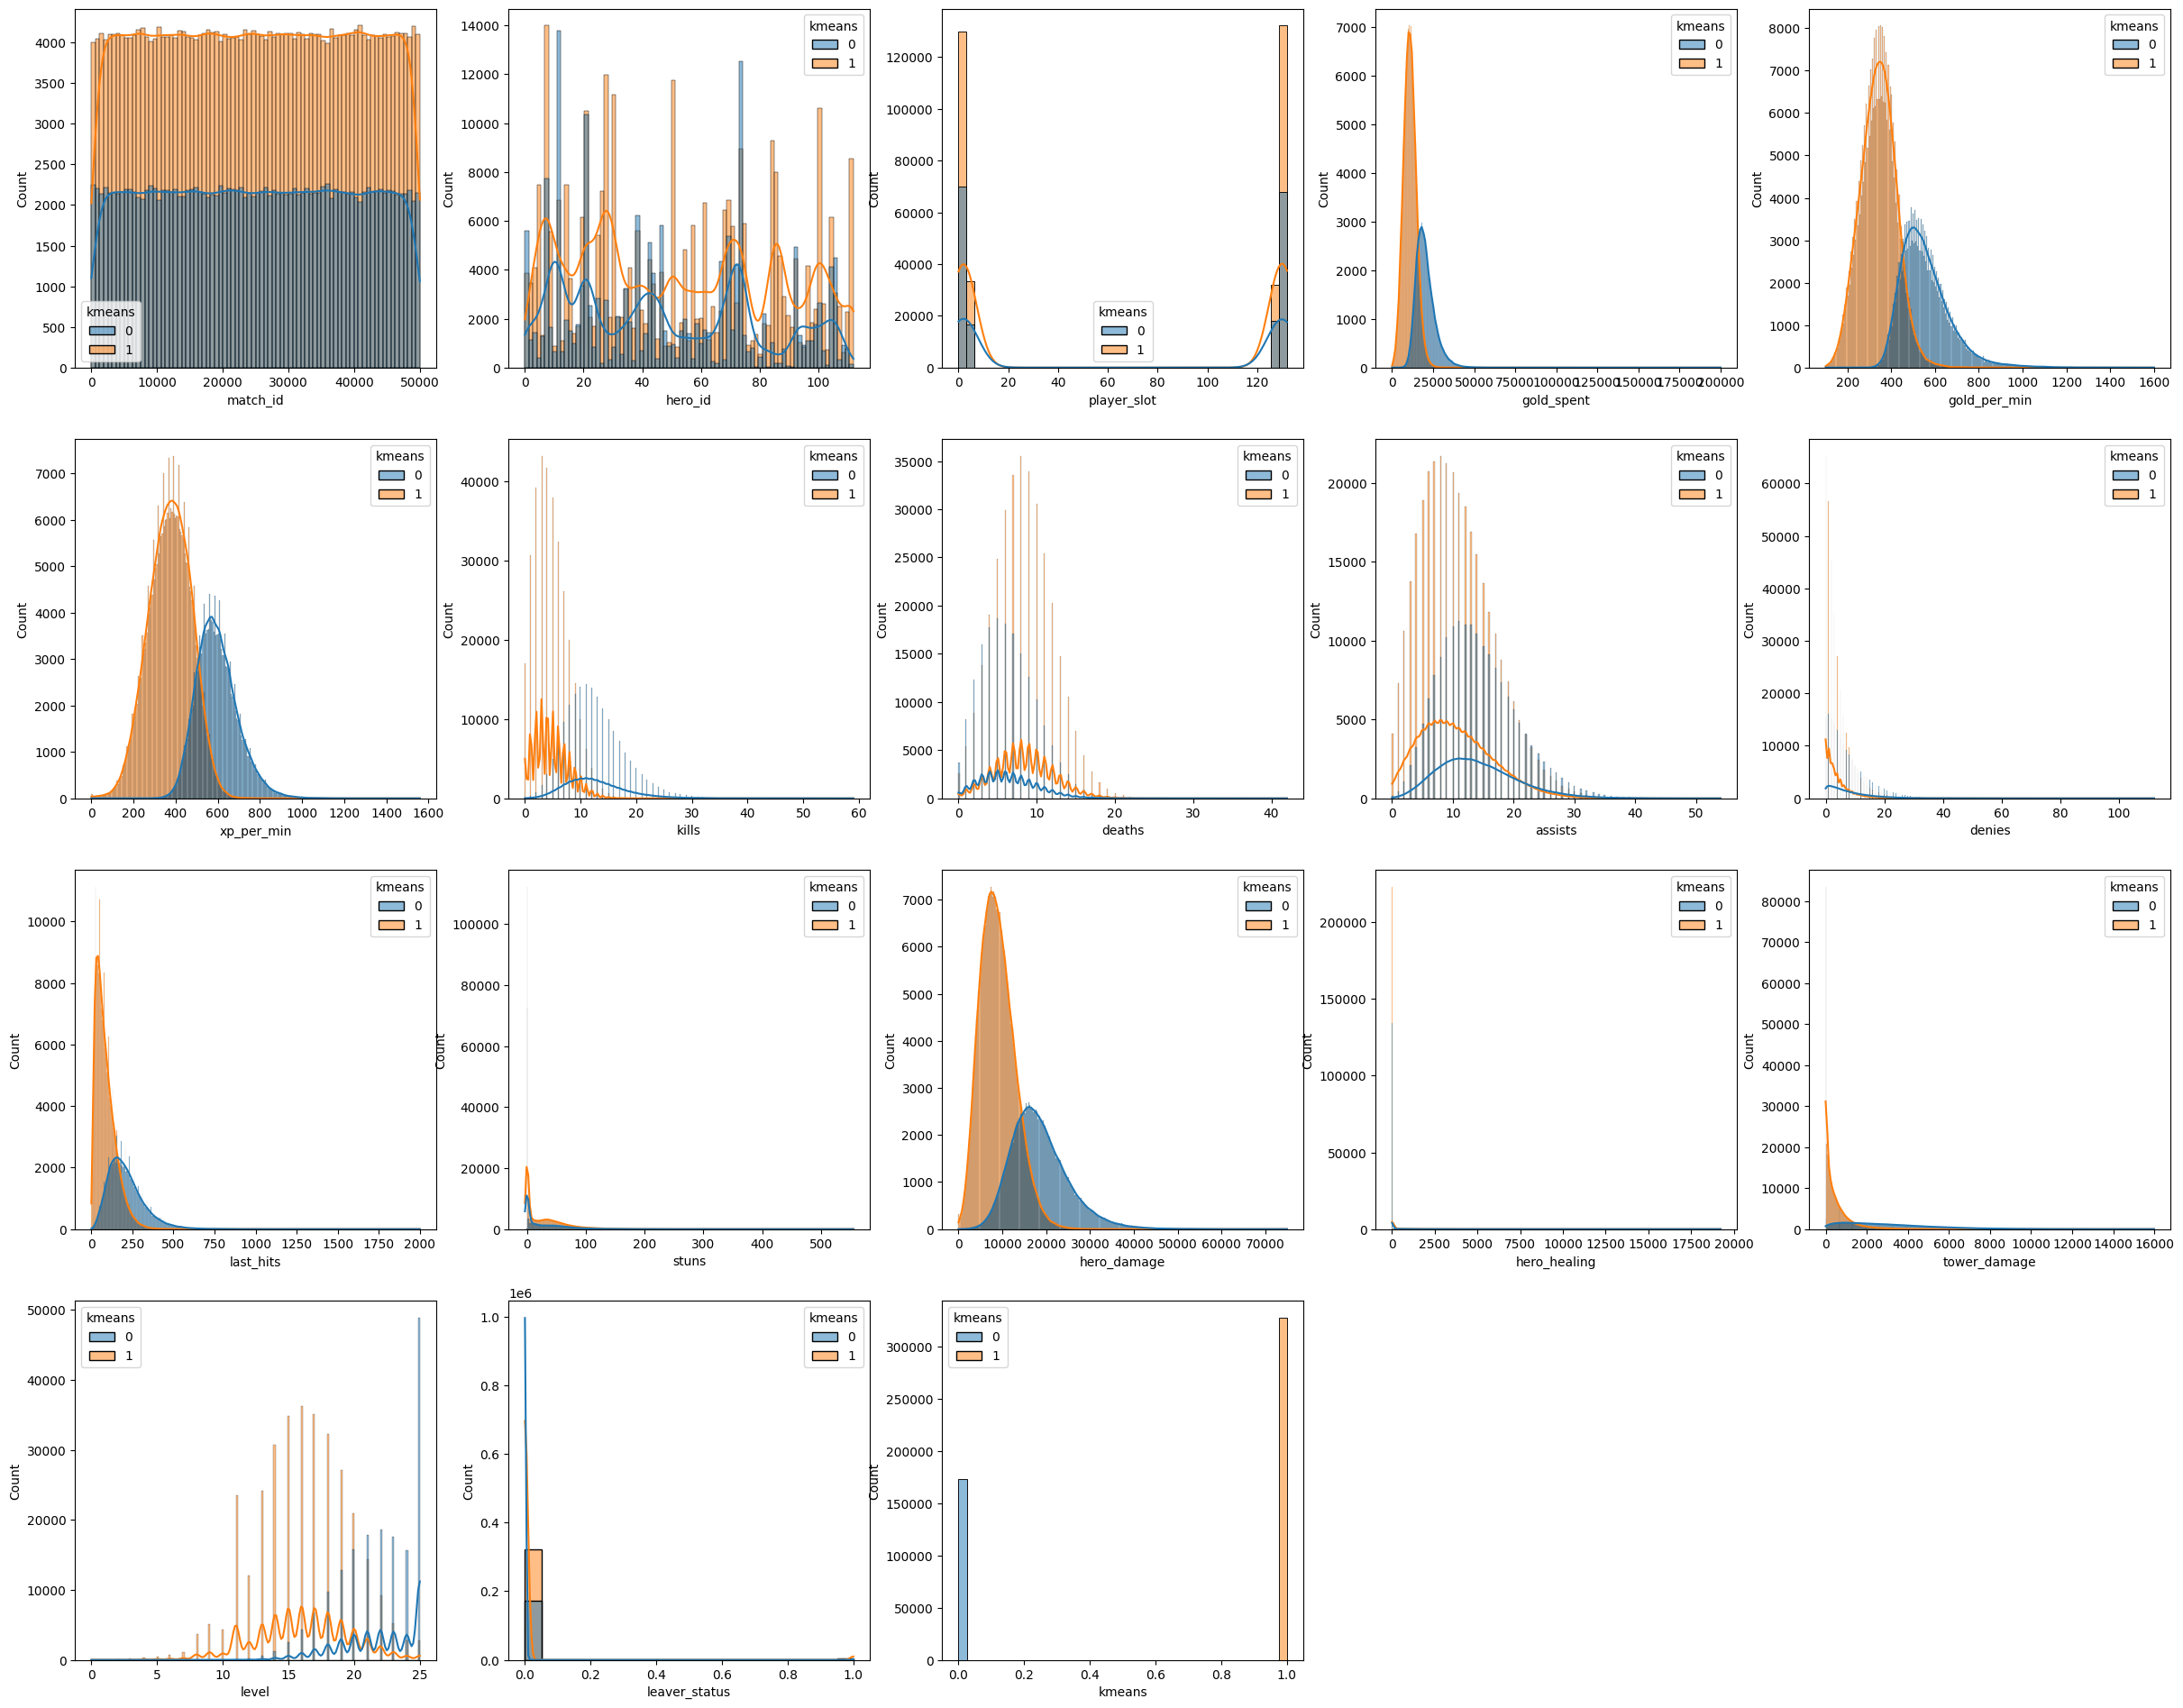

In [31]:
plotHistrogram(player_df, hue='kmeans')

##### clutering delta gold and xp each team fight

In [34]:
from multiprocessing import Pool
from src.mp_script import clusterKMean
from functools import partial

if __name__ ==  '__main__':
    scaler = MinMaxScaler()
    teamfight_cluster_df = teamfight_status[['radiant_total_delta_gold', 'dire_total_delta_gold', 'radiant_total_delta_xp', 'dire_total_delta_xp']]
    x_scale = scaler.fit_transform(teamfight_cluster_df.values)
    scale_df = pd.DataFrame(x_scale, columns=teamfight_cluster_df.columns)
    with Pool(processes=16) as p:
        output = p.map(partial(clusterKMean, scale_df), range(2,11,1))
        p.close()
        p.join()
        print('finish')
